## Analysis of recommenders

In [1]:
from Utils.import_recommenders import *

C:\Users\Martim\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
C:\Users\Martim\AppData\Local\Programs\Python\Python39\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
import os
from Utils.Dataset import Dataset

dataset = Dataset(path='./Data', validation_percentage=0, test_percentage=0.2, seed=1234)
stacked_URM, _ = dataset.stack_URM_ICM(dataset.URM_train, dataset.ICM)
output_folder_path = os.path.join('Recommenders', 'saved_models', 'test'+os.sep)

In [3]:
EASE_R_test = EASE_R(stacked_URM)
EASE_R_test.load_model(output_folder_path)

ItemKNN_CFCBF_Hybrid_test = ItemKNN_CFCBF_Hybrid(stacked_URM, dataset.ICM)
ItemKNN_CFCBF_Hybrid_test.load_model(output_folder_path)

ItemKNNCF_test = ItemKNNCF(stacked_URM)
ItemKNNCF_test.load_model(output_folder_path)

PureSVD_test = PureSVD(stacked_URM)
PureSVD_test.load_model(output_folder_path)

PureSVDItem_test = PureSVDItem(stacked_URM)
PureSVDItem_test.load_model(output_folder_path)

SLIMElasticNet_test = MultiThreadSLIM_SLIMElasticNet(stacked_URM)
SLIMElasticNet_test.load_model(output_folder_path)

UserKNNCF_test = UserKNNCF(stacked_URM)
UserKNNCF_test.load_model(output_folder_path)

Hybrid_test = Hybrid(stacked_URM, dataset.ICM)
Hybrid_test.fit()

ItemKNN_CFCBF_Hybrid: Loading model from file Recommenders\saved_models\test\ItemKNN_CFCBF_Hybrid
ItemKNN_CFCBF_Hybrid: Loading complete
PureSVD: Loading model from file Recommenders\saved_models\test\PureSVD
PureSVD: Loading complete
PureSVDItem: Loading model from file Recommenders\saved_models\test\PureSVDItem
PureSVDItem: Loading complete


In [4]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(dataset.URM_train).indptr)
profile_length, profile_length.shape

(array([141, 499, 111, ..., 214, 150, 257], dtype=int32), (13650,))

In [5]:
num_split = 10

In [6]:
block_size = int(len(profile_length)*(1/num_split))
block_size

1365

In [7]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 1648, 10647, 11672, ...,  1141,  8526,   317], dtype=int64)

In [8]:
for group_id in range(0, num_split):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 1365, average p.len 53.08, median 54.0, min 5, max 90
Group 1, #users in group 1365, average p.len 118.51, median 119.0, min 91, max 144
Group 2, #users in group 1365, average p.len 165.09, median 165.0, min 144, max 186
Group 3, #users in group 1365, average p.len 206.68, median 206.0, min 186, max 228
Group 4, #users in group 1365, average p.len 250.46, median 251.0, min 228, max 272
Group 5, #users in group 1365, average p.len 295.00, median 295.0, min 272, max 319
Group 6, #users in group 1365, average p.len 344.91, median 344.0, min 319, max 373
Group 7, #users in group 1365, average p.len 410.14, median 409.0, min 373, max 452
Group 8, #users in group 1365, average p.len 507.54, median 503.0, min 452, max 577
Group 9, #users in group 1365, average p.len 746.42, median 690.0, min 577, max 1733


In [9]:
from Utils.import_recommenders import *

MAP_recommender_per_group = {}

recommenders = {
    'ItemKNNCF': ItemKNNCF_test,
    'UserKNNCF': UserKNNCF_test,
    'EASE_R': EASE_R_test,
    'SLIMElasticNet': SLIMElasticNet_test,
    'ItemKNN_CFCBF_Hybrid': ItemKNN_CFCBF_Hybrid_test,
    'Hybrid': Hybrid_test,
    }

recommender_object_dict = {}

for label, recommender_object in recommenders.items():
    recommender_object_dict[label] = recommender_object

In [10]:
from Utils.Evaluator import EvaluatorHoldout

for group_id in range(0, num_split):
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    users_in_group = sorted_users[start_pos:end_pos]
    users_in_group_p_len = profile_length[users_in_group]
    
    print('Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}'.format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(dataset.URM_test, cutoff_list=[10], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[10]['MAP'])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[10]['MAP']]
        

Group 0, #users in group 1365, average p.len 53.08, median 54.0, min 5, max 90
EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12285 Users
EvaluatorHoldout: Processed 1359 (100.0%) in 0.31 sec. Users per second: 4328
EvaluatorHoldout: Processed 1359 (100.0%) in 0.48 sec. Users per second: 2831
EvaluatorHoldout: Processed 1359 (100.0%) in 0.85 sec. Users per second: 1593
EvaluatorHoldout: Processed 1359 (100.0%) in 0.61 sec. Users per second: 2232
EvaluatorHoldout: Processed 1359 (100.0%) in 0.36 sec. Users per second: 3775
EvaluatorHoldout: Processed 1359 (100.0%) in 2.01 sec. Users per second: 677
Group 1, #users in group 1365, average p.len 118.51, median 119.0, min 91, max 144
EvaluatorHoldout: Ignoring 13644 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12285 Users
EvaluatorHoldout: Processed 1365 (100.0%) in 0.31 sec. Users per second: 4406
EvaluatorHoldout: Processed 1365 (100.0%)

In [11]:
for label, recommender in recommender_object_dict.items():
  result_df, _ = evaluator_test.evaluateRecommender(recommender)
  if label in MAP_recommender_per_group:
      MAP_recommender_per_group[label].append(result_df.loc[10]['MAP'])
  else:
      MAP_recommender_per_group[label] = [result_df.loc[10]['MAP']]

EvaluatorHoldout: Processed 1365 (100.0%) in 0.64 sec. Users per second: 2141
EvaluatorHoldout: Processed 1365 (100.0%) in 2.91 sec. Users per second: 470
EvaluatorHoldout: Processed 1365 (100.0%) in 6.92 sec. Users per second: 197
EvaluatorHoldout: Processed 1365 (100.0%) in 2.05 sec. Users per second: 665
EvaluatorHoldout: Processed 1365 (100.0%) in 0.95 sec. Users per second: 1440
EvaluatorHoldout: Processed 1365 (100.0%) in 13.09 sec. Users per second: 104


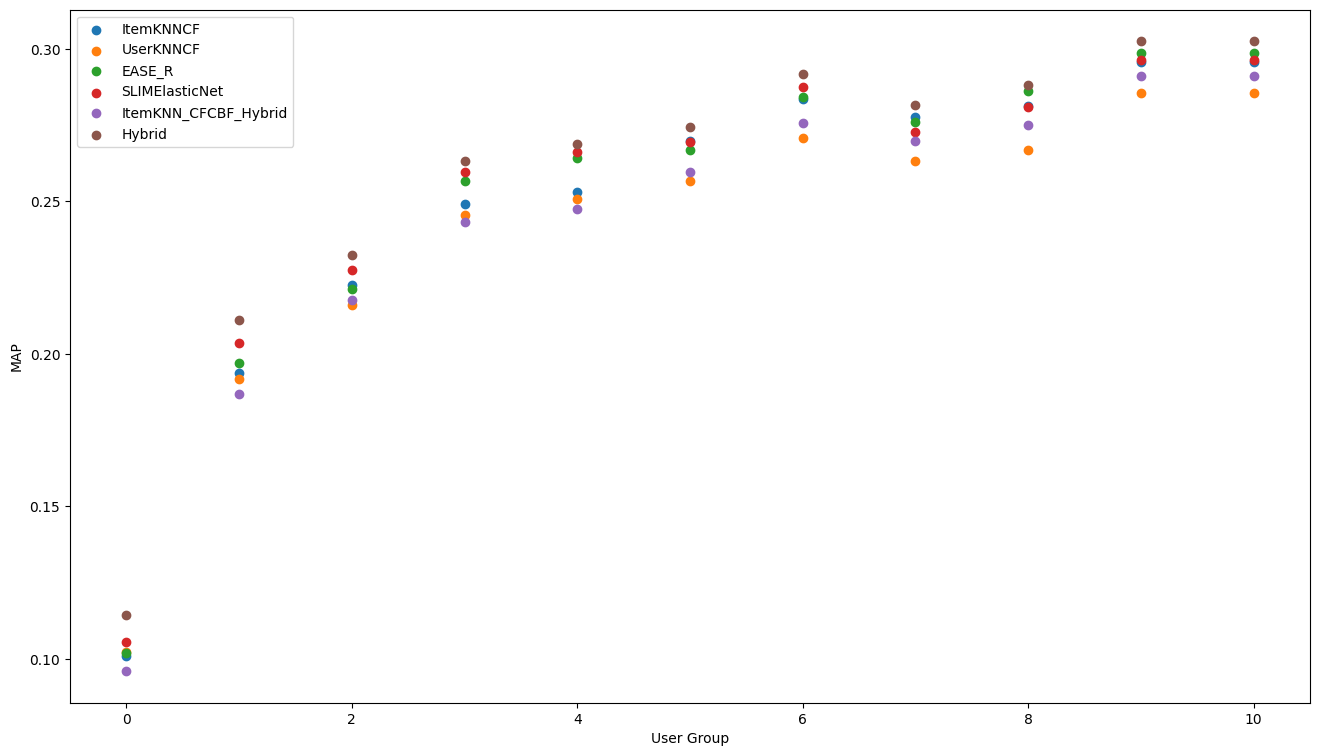

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)

plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

In [13]:
for label, recommender in recommender_object_dict.items():
    print(f'Recommender: {label}')
    results = MAP_recommender_per_group[label]
    
    for idx, res in enumerate(results): 
        print(f'\tGroup {idx}: {res}')

Recommender: ItemKNNCF
	Group 0: 0.10096969643879122
	Group 1: 0.19364750857607957
	Group 2: 0.22262047212047184
	Group 3: 0.24916439909297053
	Group 4: 0.2530525611954183
	Group 5: 0.26989787196930015
	Group 6: 0.28342016977731244
	Group 7: 0.2777620501191929
	Group 8: 0.2813352229780801
	Group 9: 0.29557738822024554
	Group 10: 0.29557738822024554
Recommender: UserKNNCF
	Group 0: 0.10240404942943565
	Group 1: 0.1918856038141751
	Group 2: 0.21608616780045306
	Group 3: 0.245431449502878
	Group 4: 0.25084571777428905
	Group 5: 0.25674007209721456
	Group 6: 0.27087845223559515
	Group 7: 0.26321594278737115
	Group 8: 0.2667599569742425
	Group 9: 0.28558235943950266
	Group 10: 0.28558235943950266
Recommender: EASE_R
	Group 0: 0.10203861382669321
	Group 1: 0.1969688935403217
	Group 2: 0.22129647072504205
	Group 3: 0.25678865050293637
	Group 4: 0.2643549334263617
	Group 5: 0.26678975521832604
	Group 6: 0.2841318972033255
	Group 7: 0.2758976103261809
	Group 8: 0.2860906157334734
	Group 9: 0.29